In [325]:
import pandas as pd
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [326]:
DATA_DIR = "../data/"

data_path = os.path.join(DATA_DIR, "new_data.csv")
df = pd.read_csv(data_path)[["Message","R2DiscussionType"]]
df = df.dropna()

display(df)
X = df["Message"]
Y = df["R2DiscussionType"]

Y.head(10)

,Message,R2DiscussionType
0,Hello.,Social
1,My assumption is,Seminar
2,that the emphasis on barbarism implies that sh...,Seminar
3,I agree with Cassandra's noticing,Seminar
4,of the author's word choice of barbarism.,Seminar
...,...,...
606,P2: The king may send his daughter to the aren...,Seminar
607,I have no guess as to which is behind the door...,Seminar
608,Part 2: The daughter is “the apple of the king...,Seminar
609,"Part 1: Honestly hard to say, though I'd like ...",Seminar


0       Social
1      Seminar
2      Seminar
3      Seminar
4      Seminar
5      Seminar
6      Seminar
7      Seminar
8    Procedure
9      Seminar
Name: R2DiscussionType, dtype: object

# explore the data

In [327]:
onehot_lookup = np.array(Y.unique())
onehot_lookup

array(['Social', 'Seminar', 'Procedure', 'Other', 'Deliberation', 'UX',
       'Imaginative entry', 'Seminar, Deliberation',
       'Social, Deliberation', 'Deliberation, Seminar',
       'Social, Procedure', 'Imaginative'], dtype=object)

In [328]:
def from_onehot(data:np.ndarray):
  data = np.argmax(data, axis=1)
  return onehot_lookup[data]

def to_onehot(data:np.ndarray):
  key=np.argsort(onehot_lookup)
  result=key[onehot_lookup[key].searchsorted(data)]

  out = np.zeros((data.shape[0], onehot_lookup.size))
  out[np.arange(out.shape[0]),result] = 1
  return out

In [329]:
print(Y.value_counts())
Y_onehot= to_onehot(Y.to_numpy())
# print(Y[3])
# print(Y_onehot[3])

R2DiscussionType
Seminar                  333
Deliberation              85
Social                    69
UX                        47
Procedure                 46
Imaginative entry         18
Other                      6
Seminar, Deliberation      2
Imaginative                2
Social, Deliberation       1
Deliberation, Seminar      1
Social, Procedure          1
Name: count, dtype: int64


In [330]:
index = 8
test = Y[index]
a = Y_onehot[index]
a = np.array([a])
print(index, test, from_onehot(a))

8 Procedure ['Procedure']


# Generate sentence embeddings

In [340]:
embeding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
X_embeddings = embeding_model.encode(X)

TypeError: len() of a 0-d tensor

In [332]:
print(X_embeddings.shape)

(611, 384)


In [333]:
from model import NeuralNet
import torch
from torch import nn

# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [334]:
X = torch.tensor(X_embeddings).float().to(device)
Y = torch.tensor(Y_onehot).float().to(device)
display(X.shape, Y.shape)

torch.Size([611, 384])

torch.Size([611, 12])

In [335]:
num_epochs = 10000
learning_rate = 1e-4

model = NeuralNet(X.shape[1], 512, Y.shape[1]).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [336]:

total_step = len(X)
i=0
for epoch in range(num_epochs):
    # for i, (inputs, labels) in enumerate(zip(X, Y)):  
    # Move tensors to the configured device
    # inputs = inputs.to(device)
    # labels = labels.to(device)
    
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, Y)
    
    # Backprpagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i+1) % 100 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    i += 1

Epoch [100/10000], Step [100/611], Loss: 1.8503
Epoch [200/10000], Step [200/611], Loss: 1.1430
Epoch [300/10000], Step [300/611], Loss: 0.8949
Epoch [400/10000], Step [400/611], Loss: 0.7527
Epoch [500/10000], Step [500/611], Loss: 0.6479
Epoch [600/10000], Step [600/611], Loss: 0.5607
Epoch [700/10000], Step [700/611], Loss: 0.4848
Epoch [800/10000], Step [800/611], Loss: 0.4174
Epoch [900/10000], Step [900/611], Loss: 0.3575
Epoch [1000/10000], Step [1000/611], Loss: 0.3045
Epoch [1100/10000], Step [1100/611], Loss: 0.2584
Epoch [1200/10000], Step [1200/611], Loss: 0.2188
Epoch [1300/10000], Step [1300/611], Loss: 0.1850
Epoch [1400/10000], Step [1400/611], Loss: 0.1564
Epoch [1500/10000], Step [1500/611], Loss: 0.1321
Epoch [1600/10000], Step [1600/611], Loss: 0.1117
Epoch [1700/10000], Step [1700/611], Loss: 0.0946
Epoch [1800/10000], Step [1800/611], Loss: 0.0804
Epoch [1900/10000], Step [1900/611], Loss: 0.0688
Epoch [2000/10000], Step [2000/611], Loss: 0.0594
Epoch [2100/10000]

In [364]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

with torch.no_grad():
  y_hat = model(X)

Y_amax = Y.detach().cpu().numpy()
Y_hat_amax = y_hat.detach().cpu().numpy()

cm = confusion_matrix(from_onehot(Y_amax),from_onehot(Y_hat_amax))

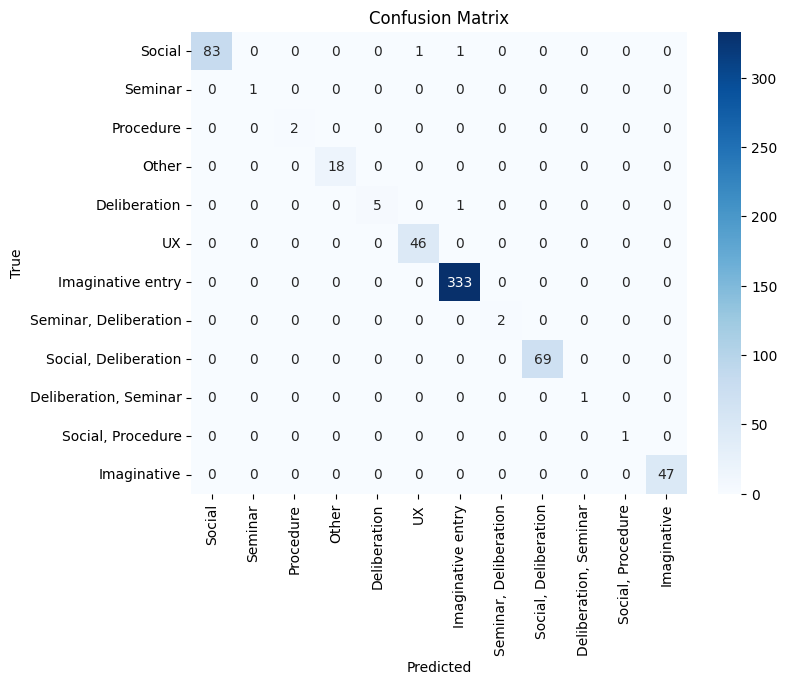

In [361]:
# Create confusion matrix

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=onehot_lookup, yticklabels=onehot_lookup)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# custom prediction

In [356]:
text = ["Hello", "princess should kill the lion", "job submited"]
embedded = embeding_model.encode(text)
embedded = torch.tensor(embedded)
with torch.no_grad():
  out = model(embedded)

print(from_onehot(out))

['Social' 'Seminar' 'UX']
